**Outlier detection using T-SNE and One-class-SVM**  

In this notebook, we will read in one frame from a sequnce of images. The images were captured with a longwave, infrared, degree-of-focalplane polarimeter, or more simply, an infrared camera with a repeated pattern of 4 filters across the individual sensor pixels. So any one of the individual sensors in the 640x512 camera has overlain one of the following four linear polarizing filters: 90 deg., 0 deg., 135 deg., or 45 deg. They are arranged on the focal plane in the following order:  

             90   0    90   0    90   0    90  ...  90 
             135  45   135  45   135  45   135 ...  135 
             90   0    90   0    90   0    90  ...  90 
             135  45   135  45   135  45   135 ...  135 
             .    .    .    .    .    .    .        . 
             .    .    .    .    .    .    .        . 
             .    .    .    .    .    .    .        . 
             90   0    90   0    90   0    90  ...  90  
             

First, we will import some modules. One of the modules, read_grave, is to read the image sequence stored in its peculiar binary format. A second, get_superPix_locs, I wrote because we will want to divide the full-sized image into component 90, 0, 135, and 45 sub-images and I wanted to be able to identify a pixel location in the full image to the best pixel location in the sub images for turning down over-performing pixels. But, please don't worry about that, just consider it a black box. We wouldn't even need to use it if there were no over-performers. 

In [2]:
import numpy as np
from sys import path as spath
spath.append('/home/foresterd/drfpy/grave_IO')
import read_grave as rg
spath.append('/home/foresterd/drfpy/bad_pixels')
import get_superPix_locs as gspl
import matplotlib.pyplot as plt

In [3]:
# The file to read
infile = './Clinton_and_Church.raw'

In [4]:
# mark bad pixels for this set
ylst = [188,161]
xlst = [235,139]

badPixels = (np.array(ylst, dtype=np.uint16), # y (rows)
             np.array(xlst, dtype=np.uint16)) # x (cols)
badSuperPix = gspl.get_superPix_locs(badPixels)

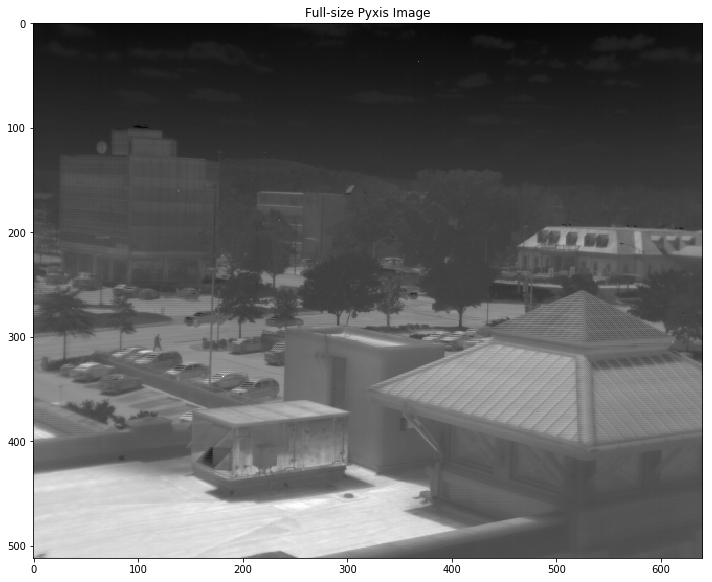

In [5]:
# Read the camera data

nFramesToRead = 1 # -1 means read all frames
frame_list, frameHdrList = rg.read_grave(infile, nFramesToRead)
imgH, imgW = frame_list[0].shape

Img = np.array(frame_list[-1])
Img[badSuperPix] = np.mean(Img) # mean-correct the 4-block bad super-pixel

#Plot the full-size image
# Set figure width to imgW/10 and height to imgH/10
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = imgW/52
fig_size[1] = imgH/52
plt.grid(False)
plt.rcParams["figure.figsize"] = fig_size
plt.imshow(Img, cmap='gray')
plt.title('Full-size Pyxis Image')
plt.show()

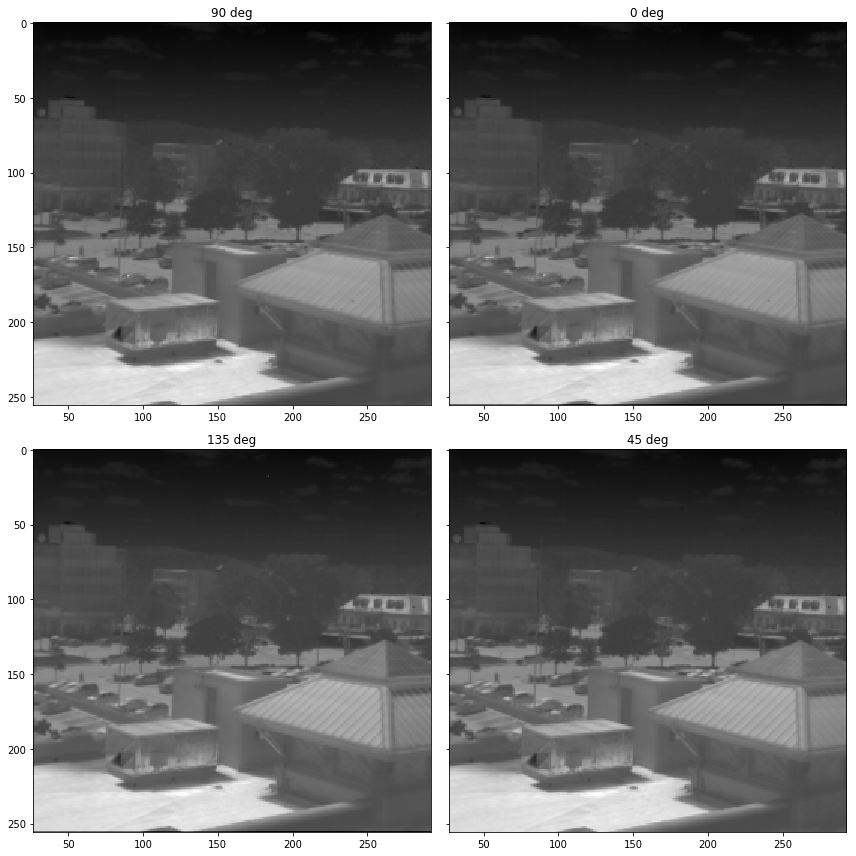

In [7]:
# Separate the image into it's four filter components

from skimage.transform import warp, AffineTransform

r, c = (int(imgH/2), int(imgW/2)) # row and column sizes for the filter component images

# define the locations of the four differently polarized sensors
p90 = [[i+j*imgW for i in range(imgW) if i%2==0]for j in range(imgH) if j%2==0]
p90idx = np.array([item for sublist in p90 for item in sublist]) # combine lists

p0 = [[i+1+j*imgW for i in range(imgW) if i%2==0]for j in range(imgH) if j%2==0]
p0idx = np.array([item for sublist in p0 for item in sublist]) # combine lists

p135 = [[i+j*imgW for i in range(imgW) if i%2==0]for j in range(imgH) if j%2==1]
p135idx = np.array([item for sublist in p135 for item in sublist]) # combine lists

p45 = [[i+1+j*imgW for i in range(imgW) if i%2==0]for j in range(imgH) if j%2==1]
p45idx = np.array([item for sublist in p45 for item in sublist]) # combine lists


fdata = Img.flatten()
I_90 = fdata[p90idx].reshape([r,c]) # reshape into an r x c image
I_0 = fdata[p0idx].reshape([r,c]) # reshape into an r x c image
I_135 = fdata[p135idx].reshape([r,c]) # reshape into an r x c image
I_45 = fdata[p45idx].reshape([r,c]) # reshape into an r x c image

# spatial alignment of the four p images
# The sensors of the four sub-images were not imaging exactly the same scene since they are 
# physically separated on the focal-plane. In other words, pixel (i,j) of the 90 degree sub-
# image does not exactly align with pixel (i,j) of any of the other three sub-images. This
# alignment error is not great, but we will correct anyway to avoid the unintentional
# creation of false edges. Correct using the AffineTransform.
dr,dc = (0.25, 0.25)

tform =  AffineTransform(translation=(dr, dc))
I_90 = warp(I_0, tform.inverse)
tform =  AffineTransform(translation=(dr, -dc))
I_0 = warp(I_0, tform.inverse)
tform =  AffineTransform(translation=(-dr, -dc))
I_135 = warp(I_135, tform.inverse)
tform =  AffineTransform(translation=(-dr, dc))
I_45 = warp(I_45, tform.inverse)

# Show images
plt.clf()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharey=True)
cm = plt.get_cmap('gray')
axes[0, 0].imshow(I_90, cmap=cm)
axes[0, 0].set_title('90 deg', fontsize=12)
axes[0, 0].grid(False)
axes[0, 1].imshow(I_0, cmap=cm)
axes[0, 1].set_title('0 deg', fontsize=12)
axes[0, 1].grid(False)
axes[1, 0].imshow(I_135, cmap=cm)
axes[1, 0].set_title('135 deg', fontsize=12)
axes[1, 0].grid(False)
axes[1, 1].imshow(I_45, cmap=cm)
axes[1, 1].set_title('45 deg', fontsize=12)
axes[1, 1].grid(False)
plt.tight_layout()
plt.show()


[[  1.82398382e+02   5.12094441e+01  -6.75094415e+02   1.06679049e-12]
 [  7.86264636e+01  -7.42271659e+01   7.20675810e+02   1.19309528e-12]
 [ -2.09610136e+02   5.91817519e+00  -6.02191006e+02   1.02642218e-12]
 [ -5.14147884e+01   1.70993461e+01   5.56580409e+02   1.12350525e-12]]


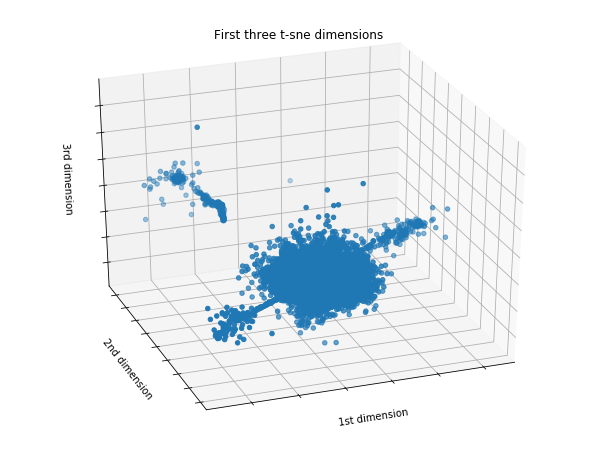

In [10]:
# t-SNE dimensionality reduction

arr = np.zeros((r, c, 4), dtype=np.float64)
arr[:,:,0] = I_90
arr[:,:,1] = I_0
arr[:,:,2] = I_135
arr[:,:,3] = I_45

X = np.reshape(arr, (r*c, 4))
#print('X.shape:', X.shape)

from sklearn import manifold
# subtract the mean value from X
X_msub = X.copy() - np.mean(X)
tsne = manifold.TSNE(n_components=4, init='pca', random_state=0).fit(X_msub.T)
trans_data = tsne.fit_transform(X_msub.T)
print(trans_data)
X_disp = np.dot(X, trans_data)

# plot the first three dimensions
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_disp[:, 0], X_disp[:, 1], X_disp[:, 2], cmap=plt.cm.Paired)
ax.set_title("First three t-sne dimensions")
ax.set_xlabel("1st dimension")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd dimension")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd dimension")
ax.w_zaxis.set_ticklabels([])


plt.show()

The 3D plot of the T-SNE above reveals that most pixels behave similarly, but that some are markedly different. Is there a way we can identify these outlying pixels in the plot above without making any assumptions about the inlying ones?

A One-class SVM can give useful results in such a situation. It can be computationally expensive, but let's do it anyway; I have a few more seconds to spare. We can tell from the plot above that we are only interested in a small percentage of pixels, therefore we will set 'outliers_fraction' below to a small value.

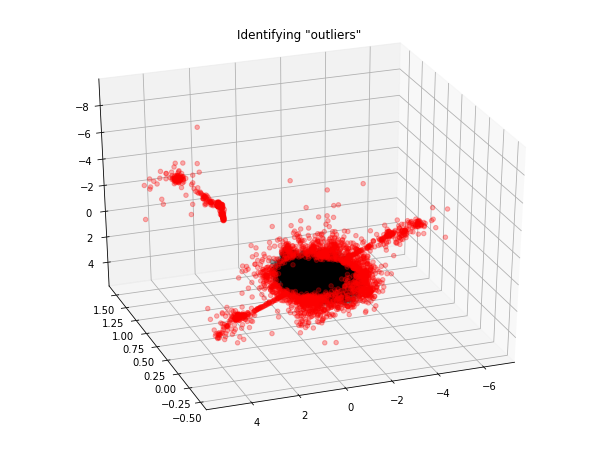

In [14]:
# Outlier detection

from sklearn import svm
from scipy import stats

outliers_fraction = 0.01
clf = svm.OneClassSVM(nu=0.03, kernel="rbf", gamma=0.1)
clf.fit(X_disp)
scores_pred = clf.decision_function(X_disp)
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
y_pred = clf.predict(X_disp)
X_reduced = np.copy(X_disp)
X_others = np.copy(X_disp)

# inliers in y_pred are marked with 1, outliers with -1
X_reduced = X_reduced[y_pred != -1]
X_others = X_others[y_pred == -1]
plt.clf()
fig = plt.figure(2, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
# show the inliers in black
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c='k', alpha=0.2)
# show the outliers in red
ax.scatter(X_others[:, 0], X_others[:, 1], X_others[:, 2], c='r', alpha=0.3)
plt.title('Identifying "outliers"')
plt.show()

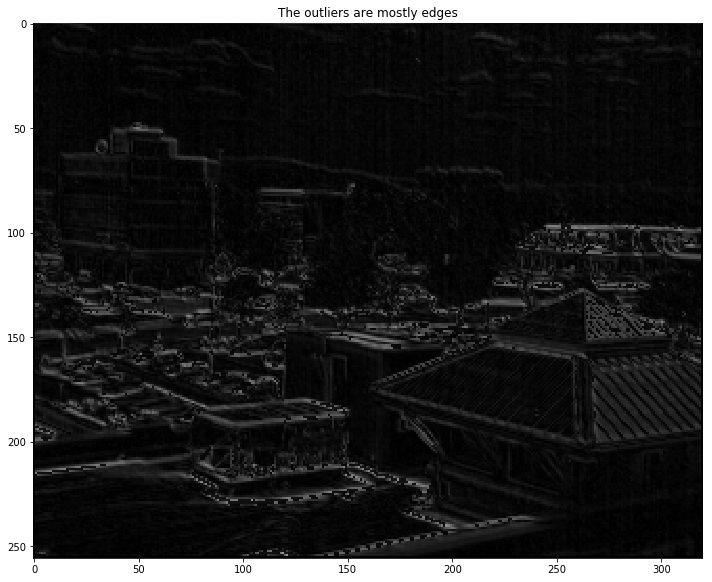

In [15]:
# show these outliers on the DoLP image

dolp = DoLP.flatten()
idx = np.where(y_pred == -1)
dolp[idx] *= np.mean(S0)

# reshape S0 back into a 2D image
DoLP_new = dolp.reshape(r,c)
DoLP_new[-1,:] = 0. # for some reason the bottom row values were very high

plt.clf()
fig = plt.figure(3)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = imgW/52
fig_size[1] = imgH/52
plt.grid(False)
plt.rcParams["figure.figsize"] = fig_size
plt.imshow(DoLP_new, cmap='gray')
plt.title('The outliers are mostly edges')
plt.show()